In [21]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from adjustText import adjust_text
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy
from surprise import SVD, KNNBaseline, BaselineOnly
import warnings
warnings.filterwarnings('ignore')

sns.set()

### Import and preprocess data

In [50]:
#read in the ratings and beer info
ratings = pd.read_csv('/Users/chrisjohanson/Documents/GitHub/Beer-Recommendation-Engine/CSVs/ratings.csv')
beers = pd.read_csv('/Users/chrisjohanson/Documents/GitHub/Beer-Recommendation-Engine/CSVs/beers.csv')


#drop null values
ratings.dropna(inplace=True)

#add user_id row mapped to the usernames
ratings['user_id'] = ratings.groupby('username').ngroup()

#combine beer_name and brewer_name to make a unique string for each beer
#because, for example, multiple beers can be named 'IPA' and they all should 
#not be counted as one beer
ratings['beer_name_clean'] = ratings['beer_name'] + ' ' + ratings['brewery_name']

#create new dataframe with only the usernames, beer names (clean), and ratings
ratings_full = ratings[['user_id', 'beer_name_clean', 'rating']].sample(frac=1)

#create a separate dataframe from ratings and only 500,000 ratings
ratings_500k = ratings.sample(frac=1)[:500000]
ratings_500k = ratings_500k[['user_id', 'beer_name_clean', 'rating']]

#create a separate dataframe from ratings and only 100000 ratings
ratings_100k = ratings.sample(frac=1)[:100000]
ratings_100k = ratings_100k[['user_id', 'beer_name_clean', 'rating']]


In [56]:
beers['beer_name_concat'] = beers['beer_name'] + ' ' + beers['brewery_name']

In [57]:
beers.head()

,Unnamed: 0,beer_name,beer_style,beer_substyle,brewery_name,abv,beer_name_concat
0,0,Samuel Adams Winter Lager,Bocks,German Bock,Boston Beer Company (Samuel Adams),5.6,Samuel Adams Winter Lager Boston Beer Company ...
1,1,Shiner Bock,Bocks,German Bock,Spoetzl Brewery,4.4,Shiner Bock Spoetzl Brewery
2,2,Samuel Adams Chocolate Bock,Bocks,German Bock,Boston Beer Company (Samuel Adams),5.8,Samuel Adams Chocolate Bock Boston Beer Compan...
3,3,Michelob AmberBock,Bocks,German Bock,Anheuser-Busch,5.2,Michelob AmberBock Anheuser-Busch
4,4,Samuel Adams Cherry Chocolate Bock,Bocks,German Bock,Boston Beer Company (Samuel Adams),5.8,Samuel Adams Cherry Chocolate Bock Boston Beer...


### Load data in to Surprise Datasets

In [3]:
reader = Reader(rating_scale=(1, 5))
dataset_100k = Dataset.load_from_df(ratings_100k, reader)
dataset_500k = Dataset.load_from_df(ratings_500k, reader)
dataset_full = Dataset.load_from_df(ratings_full, reader)

In [4]:
trainset_100k, testset_100k = train_test_split(dataset_100k, test_size=.2)
trainset_500k, testset_500k = train_test_split(dataset_500k, test_size=.2)
trainset_full, testset_full = train_test_split(dataset_full, test_size=.2)

### Run a benchmark test for all algorithms to see which perform the best (lowest RMSE). Choose the top 3 algorithms, tune their hyperparameters, and check the new RMSEs to find the best performer.

##### NOTE: Running the benchmnark test is computationally expensive and not possible to run via Jupyter Notebook. The tests were run in separate python script (using 200k sample dataset) and the results are below:

In [5]:
#import the results
algo_test_1_results = pd.read_csv('/Users/chrisjohanson/Documents/GitHub/Beer-Recommendation-Engine/CSVs/results_df1.csv')
algo_test_2_results = pd.read_csv('/Users/chrisjohanson/Documents/GitHub/Beer-Recommendation-Engine/CSVs/results_df2.csv')
algo_test_3_results = pd.read_csv('/Users/chrisjohanson/Documents/GitHub/Beer-Recommendation-Engine/CSVs/results_df3.csv')

In [6]:
#concatenate the results and put in pandas DataFrame
benchmark_results = pd.concat([algo_test_1_results, algo_test_2_results, 
                               algo_test_3_results]).set_index('Algorithm').sort_values('test_rmse')

benchmark_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.466791,0.333192,28.431744,1.672278
BaselineOnly,0.474703,0.336193,0.604485,0.398242
SVD,0.475610,0.341045,7.663958,0.557649
KNNBaseline,0.500009,0.360180,65.941233,10.083114
KNNBasic,0.567782,0.408439,63.054044,9.482681
NMF,0.582373,0.430775,10.577674,0.507602
KNNWithMeans,0.607415,0.441040,79.986898,10.053095
KNNWithZScore,0.616596,0.442310,72.427948,10.281441
SlopeOne,0.655678,0.487593,0.997676,1.263844


### Plot the results of the benchmark test

22

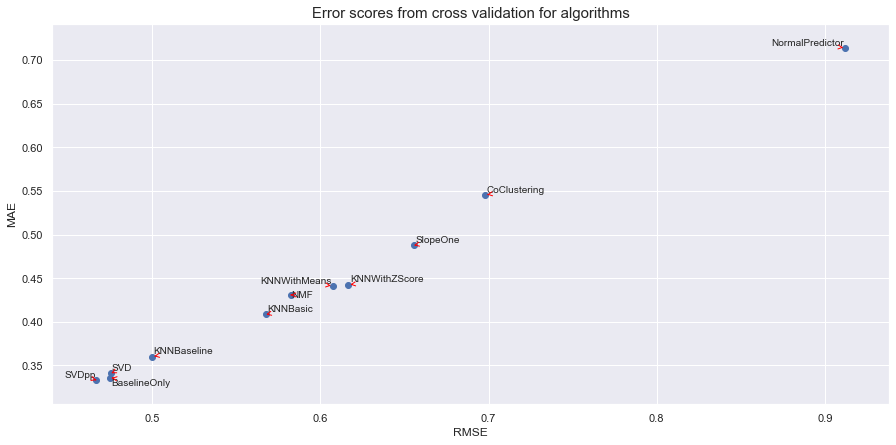

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))

x = benchmark_results['test_rmse']
y = benchmark_results['test_mae']

_ = plt.scatter(x, y)
_ = plt.title('Error scores from cross validation for algorithms', fontsize=15)
_ = plt.xlabel('RMSE')
_ = plt.ylabel('MAE')
texts = [plt.text(x[i], y[i], txt, ha='center', va='center' ) for i, txt in enumerate(benchmark_results.index)]

adjust_text(texts, x=x, y=y, force_points=0.1, arrowprops={'arrowstyle':'->', 'color':'red'})


##### The NormalPredictor results were dropped because it has no predictive ability and is used for comparison purposes

In [8]:
#remove NormalPredictor because it is not a predictive algorithm
benchmark_results = benchmark_results.drop('NormalPredictor')
benchmark_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.466791,0.333192,28.431744,1.672278
BaselineOnly,0.474703,0.336193,0.604485,0.398242
SVD,0.475610,0.341045,7.663958,0.557649
KNNBaseline,0.500009,0.360180,65.941233,10.083114
KNNBasic,0.567782,0.408439,63.054044,9.482681
NMF,0.582373,0.430775,10.577674,0.507602
KNNWithMeans,0.607415,0.441040,79.986898,10.053095
KNNWithZScore,0.616596,0.442310,72.427948,10.281441
SlopeOne,0.655678,0.487593,0.997676,1.263844


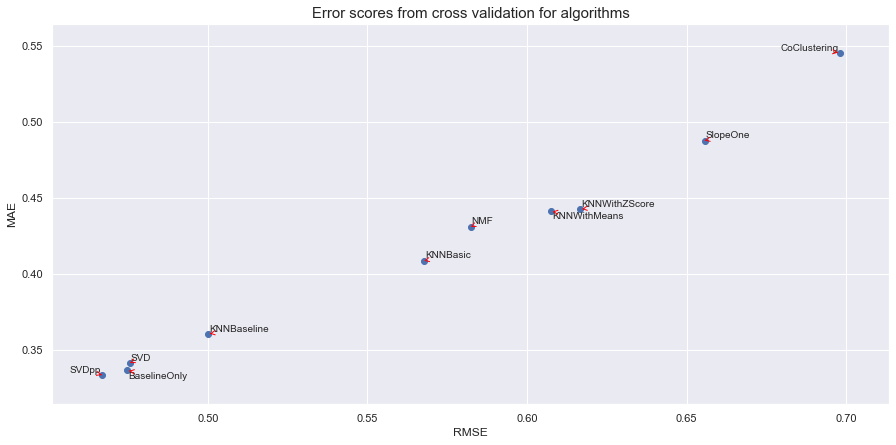

In [9]:
fig, ax = plt.subplots(figsize=(15, 7))

x = benchmark_results['test_rmse']
y = benchmark_results['test_mae']

_ = plt.scatter(x, y)
_ = plt.title('Error scores from cross validation for algorithms', fontsize=15)
_ = plt.xlabel('RMSE')
_ = plt.ylabel('MAE')
texts = [plt.text(x[i], y[i], txt, ha='center', va='center' ) for i, txt in enumerate(benchmark_results.index)]



adjust_text(texts, x=x, y=y, force_points=0.1, arrowprops={'arrowstyle':'->', 'color':'red'})

plt.savefig('benchmark.png')

### The top 4 results are: SVDpp, BaselineOnly, SVD, and KNNBaseline. 
BaselineOnly is not a predictive algorithm, but will be included for comparison purposes. SVDpp will be removed from consideration. Even though it is clearly the best in terms of performance, it is too computationally expensive for the limited computer power that is available at hand. SVD and KNNBaseline are ultimately going to be the two algorithms that will be hypertuned to find the best estimator, with the likely result being that SVD performs better.

In [10]:
algos_top_3 = benchmark_results.loc[['BaselineOnly', 'SVD', 'KNNBaseline']]
algos_top_3

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,0.474703,0.336193,0.604485,0.398242
SVD,0.475610,0.341045,7.663958,0.557649
KNNBaseline,0.500009,0.360180,65.941233,10.083114


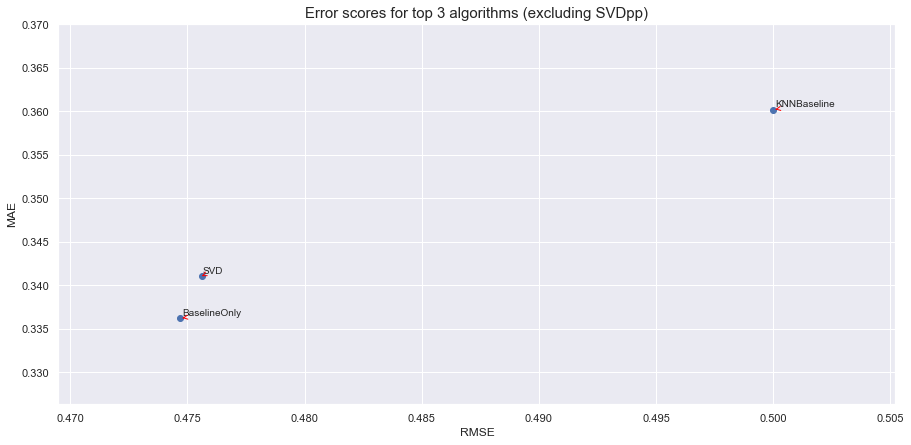

In [11]:
fig, ax = plt.subplots(figsize=(15, 7))

x = algos_top_3['test_rmse']
y = algos_top_3['test_mae']

_ = plt.title('Error scores for top 3 algorithms (excluding SVDpp)', fontsize=15)
_ = plt.xlabel('RMSE')
_ = plt.ylabel('MAE')

plt.scatter(x, y)
texts = [plt.text(x[i], y[i], txt, ha='center', va='center' ) for i, txt in enumerate(algos_top_3.index)]

adjust_text(texts, x=x, y=y, force_points=0.1, arrowprops={'arrowstyle':'->', 'color':'red'})

plt.savefig('benchmark3.png')


There is a notable difference between SVD and KNNBaseline, so, as mentioned before, it is expected that SVD will have the best performance measured in terms of lowest RMSE.

### BaselineOnly (no prediction power) purely for comparison purposes

In [12]:
baseline_only_results = cross_validate(BaselineOnly(), dataset_500k, measures=['rmse'], cv=3)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [13]:
baseline_only_results_df = pd.DataFrame.from_dict(baseline_only_results)
baseline_only_rmse = baseline_only_results_df['test_rmse'].mean()
print(f"The RMSE score for the baseline is: {round(baseline_only_rmse, 3)}")

The RMSE score for the baseline is: 0.457


### SVD
##### Note: GridSearchCV will use the 100,000 sample of the full dataset because of limited computing power at hand

In [14]:
svd_param_grid = {
    'n_factors' : [100],
    'n_epochs' : [40],
    'lr_all' : [.01, .015],
    'reg_all' : [.08, .1]
}

In [15]:
svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse'], cv=3)

In [16]:
svd_gs.fit(dataset_100k)

In [17]:
svd_gs.best_params['rmse']

{'n_factors': 100, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}

In [18]:
svd_gs.best_score['rmse']

0.48477741672423996

In [19]:
svd = svd_gs.best_estimator['rmse']

In [24]:
svd.fit(trainset_full)

In [25]:
predictions = svd.test(testset_full)
svd_rmse = accuracy.rmse(predictions)

RMSE: 0.4493


### KNNBaseline

##### Note: KNNBaseline is trained on the 100,000 sample of the full dataset because of limited computing power at hand

In [26]:
knn_param_grid = {
    'k' : [10, 20, 30, 40],
    'sim_options' : {
        'name' : ['pearson_baseline']
    }
}

In [27]:
knn_gs = GridSearchCV(KNNBaseline, knn_param_grid, measures=['rmse'], cv=3)

In [28]:
knn_gs.fit(dataset_100k)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [29]:
knn_gs.best_params['rmse']

{'k': 10, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}

In [30]:
knn_gs.best_score['rmse']

0.4950214487532137

In [31]:
results = pd.DataFrame.from_dict(knn_gs.cv_results)

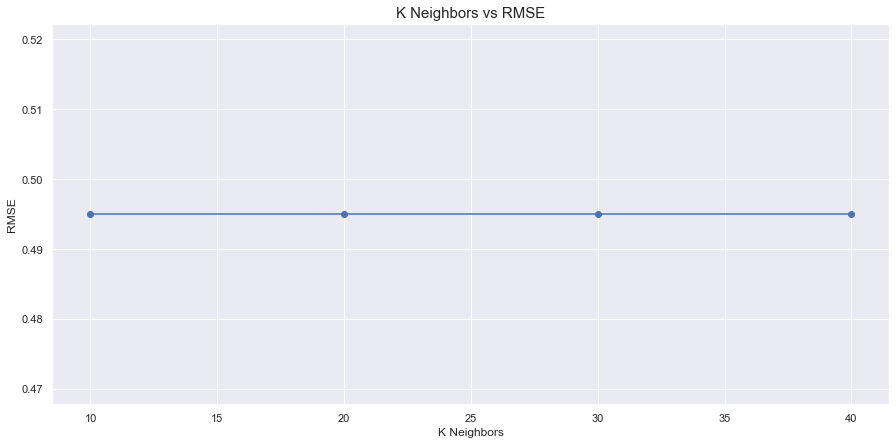

In [32]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(results['param_k'], results['mean_test_rmse'], marker='o')
_ = plt.title('K Neighbors vs RMSE', fontsize=15)
_ = plt.xlabel('K Neighbors')
_ = plt.ylabel('RMSE')
_ = plt.ticklabel_format(style='plain', useOffset=False)

plt.savefig('knn_performance.png')

The score is stable at .4989 for all values of k.

In [33]:
knn = knn_gs.best_estimator['rmse']

In [34]:
knn.fit(trainset_100k)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [35]:
predictions = knn.test(testset_100k)
knn_rmse = accuracy.rmse(predictions)


RMSE: 0.4883


### Model comparison to see which is best

In [36]:
model_comparison_info = [['BaselineOnly', baseline_only_rmse], 
                         ['SVD', svd_rmse],
                         ['KNNBaseline', knn_rmse]
                        ]
model_comparison_df = pd.DataFrame(model_comparison_info, columns=['Algorithm', 'Test RMSE']).sort_values('Test RMSE').set_index('Algorithm')
model_comparison_df

,Test RMSE
Algorithm,
SVD,0.449302
BaselineOnly,0.457144
KNNBaseline,0.488313


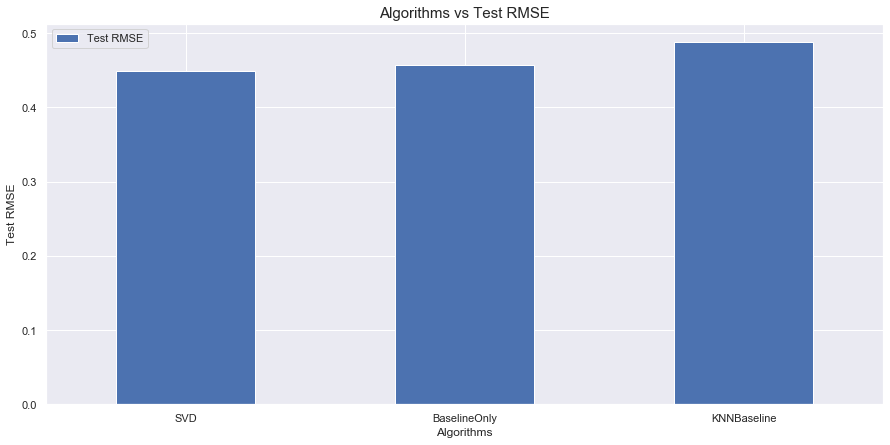

In [37]:
fig, ax = plt.subplots(figsize=(15,7))

model_comparison_df.plot.bar(ax=ax)
_ = plt.title('Algorithms vs Test RMSE', fontsize=15)
_ = plt.xlabel('Algorithms')
_ = plt.ylabel('Test RMSE')
_ = plt.xticks(rotation=0)

plt.savefig('top_model_comparison.png')

As a reminder, BaselineOnly is not a predictive algorithm and it used for comparison purposes only. That, of course, leaves the comparison to be made between SVD and KNNBaseline. SVD has the best performance (lowest RMSE), so it will be used as the final algorithm.

### Recommendations with SVD (best model)

##### NOTE: SVD model has already been fit to the full training set.

In [38]:
svd.qi.shape
#The first number shows how many beers there are and the second shows the number of latent features

(5505, 100)

In [39]:
#the inner id values (integer) that are mapped to raw values (string)
svd.trainset._raw2inner_id_items



{'Bretta Rosé Firestone Walker Brewing Co.': 0,
 'Hop Trip Harvest Ale (Fresh Hop Ale) Deschutes Brewery': 1,
 'Dos Equis Special Lager Cervecería Cuauhtémoc Moctezuma, S.A. de C.V.': 2,
 'King Sue Toppling Goliath Brewing Company': 3,
 'CBS (Canadian Breakfast Stout) Founders Brewing Company': 4,
 'Shiner Blonde Spoetzl Brewery': 5,
 'Pale Ale Sierra Nevada Brewing Co.': 6,
 'Iris Brasserie Cantillon': 7,
 'Florida Cracker Cigar City Brewing': 8,
 'Lucky 13 Mondo Large Red Ale Lagunitas Brewing Company': 9,
 'Franziskaner Hefe-Weisse Spaten-Franziskaner-Bräu': 10,
 'Raspberry Tart New Glarus Brewing Company': 11,
 '420 Extra Pale Ale SweetWater Brewing Company': 12,
 'Imperial Stout Founders Brewing Company': 13,
 'Fat Dog Stoudts Brewing Co.': 14,
 'Older Viscosity Port Brewing': 15,
 'Vicinity Trillium Brewing Company': 16,
 'Frangelic Mountain Brown Founders Brewing Company': 17,
 'Fortunate Islands Modern Times Beer': 18,
 'Mudpuppy Central Waters Brewing Co.': 19,
 'Green Zebra F

#### Item Similarity

In [40]:
#define functions

def get_vector_by_beer_name(beer_name, trained_model=SVD):
    """Returns the latent features of a movie in the form of a numpy array"""
    beer_name_idx = trained_model.trainset._raw2inner_id_items[beer_name]
    return trained_model.qi[beer_name_idx]


def cosine_distance(vector_a, vector_b):
    """Returns a float indicating the similarity between two vectors"""
    return cosine(vector_a, vector_b)

In [41]:
#check item similarity between Budweiser, Bud Light, and Guiness

bud_vector = get_vector_by_beer_name('Budweiser Anheuser-Busch', svd)
bl_vector = get_vector_by_beer_name('Bud Light Anheuser-Busch', svd)
guiness_vector = get_vector_by_beer_name('Guinness Original Guinness Ltd.', svd)

In [42]:
print("Budweiser compared to Budweiser:")
print(f"Cosine distance of {cosine_distance(bud_vector, bud_vector)} makes sense because the cosine similarity between two identical vectors is 0")

Budweiser compared to Budweiser:
Cosine distance of 0.0 makes sense because the cosine similarity between two identical vectors is 0


In [43]:
print("Budweiser compared to Bud Light:")
print(f"Cosine distance of {round(cosine_distance(bud_vector, bl_vector), 3)} makes sense because the two beers are very similar")

Budweiser compared to Bud Light:
Cosine distance of 0.254 makes sense because the two beers are very similar


In [44]:
print("Budweiser compared to Guiness:")
print(f"""Cosine distance of {round(cosine_distance(bud_vector, guiness_vector), 3)} makes sense because the two beers significantly different, with 
one being a pilsner and the other a stout""")

Budweiser compared to Guiness:
Cosine distance of 0.923 makes sense because the two beers significantly different, with 
one being a pilsner and the other a stout


#### What are the most similar items for a given beer?

In [45]:
#define functions

def display_sim(similarity_table):
    '''
    Outputs the similarity info in an organized DataFrame
    '''
    similarity_table = pd.DataFrame(
        similarity_table,
        columns=['beer_name', 'vector cosine distance']
    ).sort_values('vector cosine distance', ascending=True)
    return similarity_table.iloc[:5]

def get_top_similarities(beer_name, model=svd):
    """Returns the top 5 most similar beers to a specified beer
    
    This function iterates over all beers in the data and calculates
    the cosine distance between `beer_name` vector and that beer's vector
    """
    
    # Get the first movie vector
    beer_vector: np.array = get_vector_by_beer_name(beer_name, model)
    similarity_table = []
    
    # Iterate over every possible movie and calculate similarity
    for other_beer_name in model.trainset._raw2inner_id_items.keys():
        other_beer_vector = get_vector_by_beer_name(other_beer_name, model)
        
        # Get the second movie vector, and calculate distance
        similarity_score = cosine_distance(other_beer_vector, beer_vector)
        similarity_table.append((other_beer_name, similarity_score))
    
    # sort movies by ascending similarity
    return display_sim(sorted(similarity_table))

In [110]:
#check the top similarities for Budweiser Anheuser-Busch
get_top_similarities('Budweiser Anheuser-Busch', svd)

,beer_name,vector cosine distance
867,Budweiser Anheuser-Busch,0.000000
3043,Michelob (Original Lager) Anheuser-Busch,0.144721
2345,Imperial Cerveceria Costa Rica,0.150580
1144,Coors Banquet Coors Brewing Company (Molson-Co...,0.156364
3081,Miller Genuine Draft 64 Miller Brewing Co.,0.157601


#### Recommendations via Matrix Reconstruction

In [144]:
#define function

def get_new_suggestions(user_id, model=svd):
    """
    Gives new suggestions for a user
    """
    
    #find the users top 5 rated beers
    user_top_5_rated = list(ratings[ratings['user_id']==user_id].sort_values('rating', ascending=False)['beer_name_clean'][:5])
    #put together a list of all the beers the user has rated
    beers_user_rated = list(ratings[ratings['user_id']==user_id]['beer_name_clean'].unique())
    #empty list to save the suggestions to
    suggestions = []

    #go through each of the top rated items and pull the two most similar beers,
    #then append them to the suggestions list
    for item in user_top_5_rated:
        df = get_top_similarities(item)

        recs = list(df['beer_name'])

        recs_user_not_rated = [el for el in recs if el not in beers_user_rated]

        for rec in recs_user_not_rated[:2]:
            if (rec not in suggestions) & (len(suggestions) <= 9):
                suggestions.append(rec)

                
    suggestions_df = beers[beers['beer_name_concat'].isin(suggestions)][['beer_name', 'brewery_name', 'beer_style', 'beer_substyle', 'abv']].reset_index().drop('index', axis=1)
            
    return suggestions_df

In [145]:
ratings[ratings['user_id']==10995].drop(['username', 'rating_id', 'rating_date', 'beer_name_clean'], axis=1).sort_values('rating', ascending=False)

,rating,beer_name,brewery_name,beer_style,beer_substyle,abv,user_id
787131,4.75,Fou' Foune,Brasserie Cantillon,Wild/Sour Beers,Belgian Fruit Lambic,5.50,10995
2180183,4.75,Heady Topper,The Alchemist,India Pale Ales,New England IPA,8.00,10995
2190470,4.50,Julius,Tree House Brewing Company,India Pale Ales,New England IPA,6.80,10995
1602982,4.25,Enjoy By IPA,Stone Brewing,India Pale Ales,American Imperial IPA,9.40,10995
3857968,4.25,Breakfast Stout,Founders Brewing Company,Stouts,English Oatmeal Stout,8.30,10995
233200,4.00,La Fin Du Monde,Unibroue,Strong Ales,Belgian Tripel,9.00,10995
1612429,4.00,Lagunitas Sucks,Lagunitas Brewing Company,India Pale Ales,American Imperial IPA,7.85,10995
1818110,4.00,Sculpin,Ballast Point Brewing Company,India Pale Ales,American IPA,7.00,10995


In [146]:
get_new_suggestions(10995, svd)

,beer_name,brewery_name,beer_style,beer_substyle,abv
0,Consecrator,Bell's Brewery - Eccentric Café & General Store,Bocks,German Doppelbock,8.0
1,Melcher Street,Trillium Brewing Company,India Pale Ales,New England IPA,7.2
2,Zoe,Maine Beer Company,Pale Ales,American Amber / Red Ale,7.2
3,3 MONTS (Originale),Brasserie 3 MONTS,Pale Ales,French Bière de Garde,8.5
4,Trial Of Dmitri,Benchtop Brewing Company,Specialty Beers,Russian Kvass,4.5
5,La Clef Des Champs,Brasserie Dieu du Ciel!,Specialty Beers,Scottish Gruit / Ancient Herbed Ale,5.0
6,Double Or Nothing,Otter Creek Brewing,Strong Ales,American Barleywine,10.5
7,Three Philosophers,Brewery Ommegang,Strong Ales,Belgian Quadrupel (Quad),9.7
8,Gouden Carolus Classic,Brouwerij Het Anker,Strong Ales,Belgian Strong Dark Ale,8.5
9,Blanche De Chambly,Unibroue,Wheat Beers,Belgian Witbier,5.0
